In [ ]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

## Land Cover Classification: Sentinel-2 with EuroCrops

This tutorial will walk you through the process of performing land cover classification with Sentinel-2 satellite imagery, annotated with EuroCrops, using TorchGeo library. We will start with downloading Sentinel-2 data, setting it up with EuroCrops for pixel-wise supervised classification, training a segmentation model, and finally running inference to make sense of Sentinel-2 imagery. 

Whether you are a remote sensing enthusiast or just curious about deep learning for geospatial data, this guide has something cool for you!

In [1]:
import os
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import planetary_computer
import pystac
import torch
from torch.utils.data import DataLoader
from torchgeo.datasets.utils import download_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)

### 1- Downloading Sentinel-2 Imagery

Fetch Sentinel-2 imagery using Microsoft Planetary Computer and ensure you have the data you need. Note that the Sentinel-2 imagers should match the label source both _spatially_ and _temporally_ and EuroCrops is comprised of vector-form annotations of EU countries sourced from different years. 

In [41]:
root = "/data/sentinel"
item_urls = [
    'https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2A_MSIL2A_20180421T105031_R051_T31TDJ_20201013T004807',
]
for item_url in item_urls:
    item = pystac.Item.from_file(item_url)
    signed_item = planetary_computer.sign(item)
    for band in ['B02', 'B03', 'B04', 'B08']:
        asset_href = signed_item.assets[band].href
        filename = urlparse(asset_href).path.split('/')[-1]
        download_url(asset_href, root, filename)

100%|██████████| 186555751/186555751 [00:02<00:00, 65772238.10it/s]


100%|██████████| 194305548/194305548 [00:02<00:00, 69937826.25it/s]


100%|██████████| 199262667/199262667 [00:02<00:00, 67428154.68it/s]


100%|██████████| 211472667/211472667 [00:02<00:00, 70823179.97it/s]


### 2-  Prepare Dataloader

Customize TorchGeo to align `Sentinel2` and `EuroCrops` datasets, forming an `IntersectionDataset` for pixel-wise classification task

In [2]:
from torchgeo.datasets import RasterDataset

class Sentinel2_(RasterDataset):
    filename_glob = 'T3*_B0*_10m.tif'
    filename_regex = r'^.{6}_(?P<date>\d{8}T\d{6})_(?P<band>B0[\d])'
    date_format = '%Y%m%dT%H%M%S'
    is_image = True
    separate_files = True
    all_bands = ('B02', 'B03', 'B04', 'B08')
    rgb_bands = ('B04', 'B03', 'B02')
    
    def plot(self, sample):
        # Find the correct band index order
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))

        # Reorder and rescale the image
        image = sample['image'][rgb_indices].permute(1, 2, 0)
        image = torch.clamp(image / 10000, min=0, max=1).numpy()

        # Plot the image
        fig, ax = plt.subplots()
        ax.imshow(image)

        return fig
        
import torchgeo.datasets
torchgeo.datasets.Sentinel2 = Sentinel2_

from torchgeo.datamodules import Sentinel2EuroCropsDataModule

datamodule = Sentinel2EuroCropsDataModule(
    sentinel2_paths="/data/sentinel",
    eurocrops_paths="/data/datatorchgeo",
    batch_size=16,
    patch_size=64,
    num_workers=32,
)

datamodule.setup("fit")
train_dataset = datamodule.train_dataset
datamodule.setup("validate")
val_dataset = datamodule.val_dataset
datamodule.setup("test")
test_dataset = datamodule.test_dataset

Converting EuroCrops CRS from EPSG:4326 to EPSG:32631
Converting EuroCrops res from 1e-05 to 10.0
Converting EuroCrops CRS from EPSG:4326 to EPSG:32631
Converting EuroCrops res from 1e-05 to 10.0
Converting EuroCrops CRS from EPSG:4326 to EPSG:32631
Converting EuroCrops res from 1e-05 to 10.0


In [11]:
datamodule.sentinel2.files, datamodule.sentinel2.crs, datamodule.sentinel2.bounds, datamodule.sentinel2.crs, datamodule.eurocrops.files

(['/data/sentinel/T31TDJ_20180421T105031_B02_10m.tif',
  '/data/sentinel/T31TDJ_20180421T105031_B03_10m.tif',
  '/data/sentinel/T31TDJ_20180421T105031_B04_10m.tif',
  '/data/sentinel/T31TDJ_20180421T105031_B08_10m.tif'],
 CRS.from_epsg(32631),
 BoundingBox(minx=399960.0, maxx=509760.0, miny=4790220.0, maxy=4900020.0, mint=1524307831.0, maxt=1628592031.999999),
 CRS.from_epsg(32631),
 ['/data/datatorchgeo/AT_2021/AT_2021_EC21.shp',
  '/data/datatorchgeo/BE_VLG_2021/BE_VLG_2021_EC21.shp',
  '/data/datatorchgeo/DE_LS_2021/DE_LS_2021_EC21.shp',
  '/data/datatorchgeo/DE_NRW_2021/DE_NRW_2021_EC21.shp',
  '/data/datatorchgeo/DK_2019_EC21.shp',
  '/data/datatorchgeo/EE_2021_EC21.shp',
  '/data/datatorchgeo/FR_2018/FR_2018_EC21.shp',
  '/data/datatorchgeo/HR/HR_2020_EC21.shp',
  '/data/datatorchgeo/LT_2021_EC.shp',
  '/data/datatorchgeo/LV_2021/LV_2021_EC21.shp',
  '/data/datatorchgeo/NA/ES_NA_2020_EC21.shp',
  '/data/datatorchgeo/NL_2020_EC21.shp',
  '/data/datatorchgeo/PT_2021_EC21.shp',
  '/

#### Visualize the Sentinel-2 imagery and EuroCrops Labels

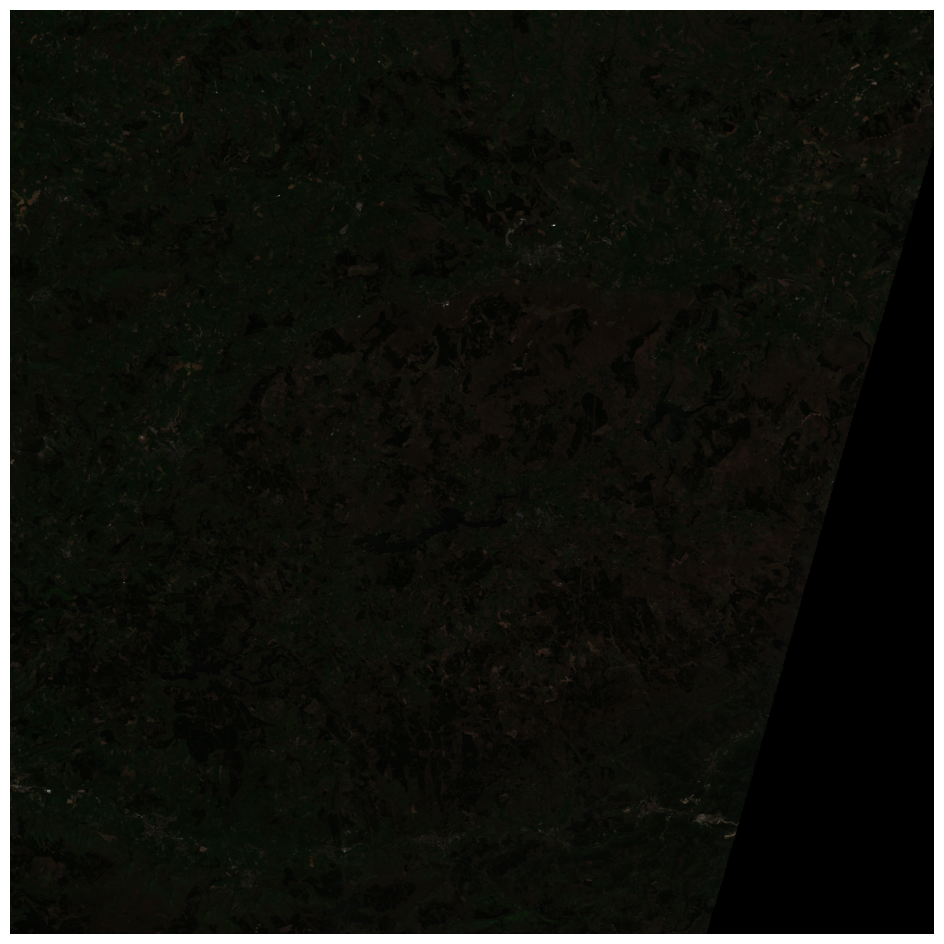

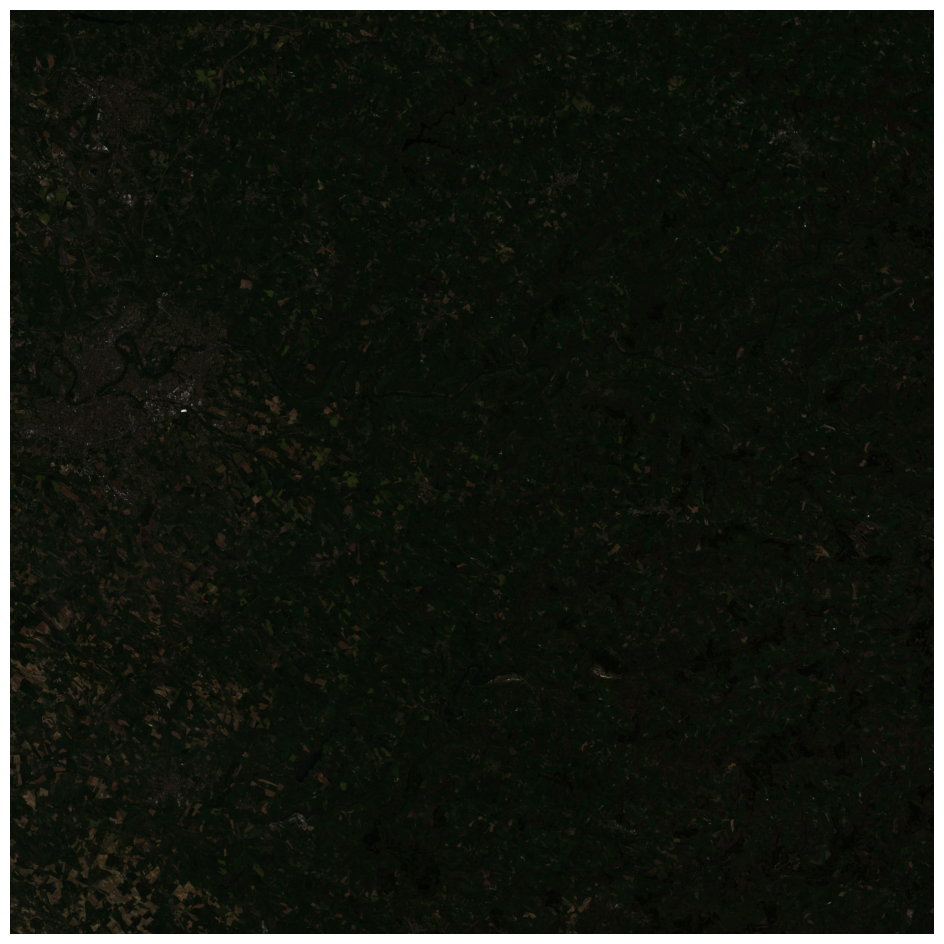

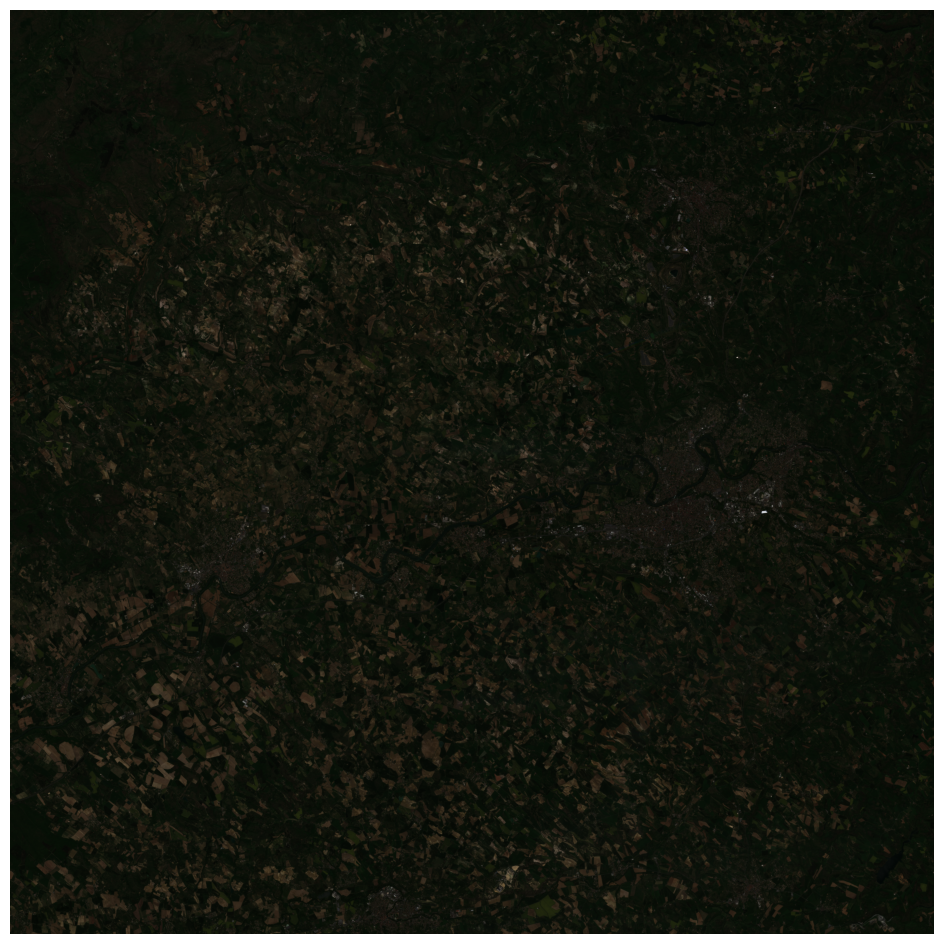

In [16]:
from torchgeo.samplers import RandomGeoSampler
from torchgeo.datasets import stack_samples, unbind_samples

dataset = Sentinel2_("/data/sentinel")
g = torch.Generator().manual_seed(1)
sampler = RandomGeoSampler(dataset, size=4096, length=3, generator=g)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

for batch in dataloader:
    sample = unbind_samples(batch)[0]
    dataset.plot(sample)
    plt.axis('off')
    plt.show()

TODO: Visualize EuroCrops instersected labels -- France

### 3- Training Semantic Segmentation Model

Train a UNet model with Sentinel-2 images paired with EuroCrops labels to classify land cover, powered by PyTorch Lightning

In [19]:
datamodule.eurocrops.class_map

{'3000000000': 1,
 '3300000000': 2,
 '3301000000': 3,
 '3301010000': 4,
 '3301010100': 5,
 '3301010101': 6,
 '3301010102': 7,
 '3301010103': 8,
 '3301010199': 9,
 '3301010200': 10,
 '3301010201': 11,
 '3301010202': 12,
 '3301010203': 13,
 '3301010299': 14,
 '3301010300': 15,
 '3301010301': 16,
 '3301010302': 17,
 '3301010303': 18,
 '3301010399': 19,
 '3301010400': 20,
 '3301010401': 21,
 '3301010402': 22,
 '3301010403': 23,
 '3301010499': 24,
 '3301010500': 25,
 '3301010501': 26,
 '3301010502': 27,
 '3301010503': 28,
 '3301010599': 29,
 '3301010600': 30,
 '3301010699': 31,
 '3301010700': 32,
 '3301010799': 33,
 '3301010800': 34,
 '3301010801': 35,
 '3301010802': 36,
 '3301010803': 37,
 '3301010899': 38,
 '3301010900': 39,
 '3301010901': 40,
 '3301010902': 41,
 '3301010903': 42,
 '3301010904': 43,
 '3301010999': 44,
 '3301011000': 45,
 '3301011001': 46,
 '3301011002': 47,
 '3301011003': 48,
 '3301011099': 49,
 '3301011100': 50,
 '3301011101': 51,
 '3301011102': 52,
 '3301011103': 53,
 '

In [ ]:
from torchgeo.trainers import SemanticSegmentationTask
from lightning.pytorch import Trainer
import torch

task = SemanticSegmentationTask(
    model='unet',
    backbone='resnet50',
    weights=None,  # TODO: Add pretrained weights
    in_channels=4,
    num_classes=396, # 395 + 1
    num_filters=3,
    loss='ce', # Either the loss or the f-f' are wrong
    class_weights=None,
    ignore_index=None,
    lr=0.001,
    patience=10,
    freeze_backbone=False,
    freeze_decoder=False)

# TODO: Trainer on CPU for now as I could not move 'input' to CUDA 
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'

trainer = Trainer(
    accelerator=accelerator,
    default_root_dir='./',
    fast_dev_run=True,
    log_every_n_steps=1,
    min_epochs=2,
    max_epochs=20,
)

trainer.fit(model=task, datamodule=datamodule)

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU av

Converting EuroCrops CRS from EPSG:4326 to EPSG:32631
Converting EuroCrops res from 1e-05 to 10.0


Training: |          | 0/? [00:00<?, ?it/s]

### 4- Model Evaluation on Test Set

Evaluate the segmentation model over the test set

### 5- Inference over full Imagery

Perform inference by computing predictions over the complete imagery 